In [ ]:
from collections import Counter
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter('ignore')
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
import requests
import urllib
import cv2
import re
from io import BytesIO
from PIL import Image
import requests, os
from os import path
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.sparse import hstack
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud

In [ ]:
# Load data set
data=pd.read_csv("db.csv")

data=data.reset_index()
data=data.rename(columns={"index":"PID"})
data.head(5)

,PID,Product_name,Product_Brand,Product_Image,Product_Price,Product_Reviews,Product_Rating,output
0,0,Replay Full Sleeves White Shirt with Regular C...,KINGDOM OF WHITE,https://m.media-amazon.com/images/I/61qKBlv1H6...,1199.0,NaN,NaN,shirt
1,1,Wave Full Sleeves White Formal Shirt with Regu...,KINGDOM OF WHITE,https://m.media-amazon.com/images/I/41lBhxltL+...,1599.0,NaN,NaN,shirt
2,2,Men's Cotton Full Sleeve Slim Fit Casual Solid...,Urbano Fashion,https://m.media-amazon.com/images/I/61NuvgzMdS...,749.0,NaN,NaN,shirt
3,3,White Solid Cotton Full Sleeves Casual Shirt f...,SHIRT THEORY,https://m.media-amazon.com/images/I/515SAzqW7t...,839.0,14.0,3.7,shirt
4,4,Men's Solid Slim Fit Cotton Casual Shirt with ...,Dennis Lingo,https://m.media-amazon.com/images/I/61XzMtVz3P...,569.0,29994.0,3.8,shirt


In [ ]:
# Checking the unique observations, datatype & null values for every feature
d = {"Feature":[i for i in data.columns], "Number of unique values":data.nunique().values, 'Data Type':data.dtypes.values, "Number of null values" : data.isnull().sum() }
description = pd.DataFrame(data = d)
description

,Feature,Number of unique values,Data Type,Number of null values
PID,PID,1777,int64,0
Product_name,Product_name,1163,object,0
Product_Brand,Product_Brand,368,object,0
Product_Image,Product_Image,1730,object,0
Product_Price,Product_Price,556,float64,0
Product_Reviews,Product_Reviews,611,float64,0
Product_Rating,Product_Rating,33,float64,0
output,output,5,object,0


In [ ]:
# Replacing null values with a predefined value (0)
data['Product_Brand'].fillna(value = "Not Given" , inplace = True)
data['Product_Reviews'].fillna(value = 0 , inplace = True)
data['Product_Rating'].fillna(value = 0 , inplace = True)
data['Product_Price'].fillna(value = 0 , inplace = True)

# Changing the data type from int to float
data["Product_Price"]=data["Product_Price"].astype(float)

In [ ]:
# Decsription of dataset
data.describe()

,PID,Product_Price,Product_Reviews,Product_Rating
count,1777.000000,1777.000000,1777.000000,1777.000000
mean,888.000000,1734.487338,1836.259426,3.339111
std,513.120031,6514.101360,7365.876919,1.459416
min,0.000000,0.000000,0.000000,0.000000
25%,444.000000,399.000000,3.000000,3.400000
50%,888.000000,781.000000,73.000000,3.800000
75%,1332.000000,1299.000000,813.000000,4.100000
max,1776.000000,103392.000000,143973.000000,5.000000


<Axes: xlabel='Product_Rating', ylabel='Density'>

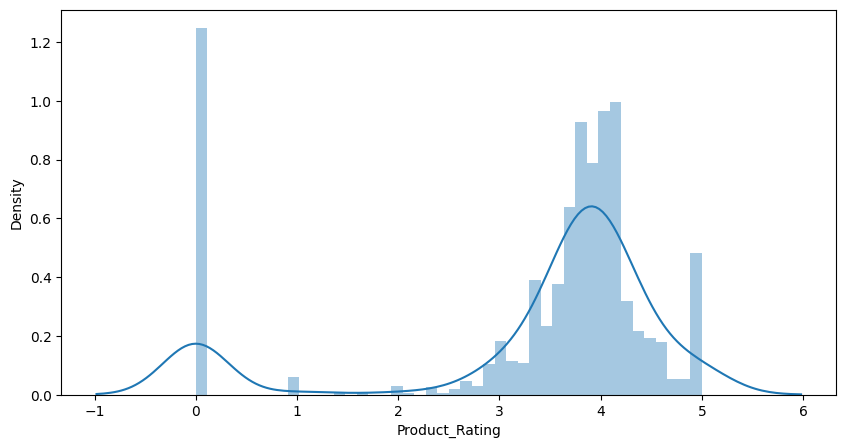

In [ ]:
# Rating distribution of product dataset
plt.figure(figsize=(10,5))
sns.distplot(data["Product_Rating"])

(0.0, 15000.0)

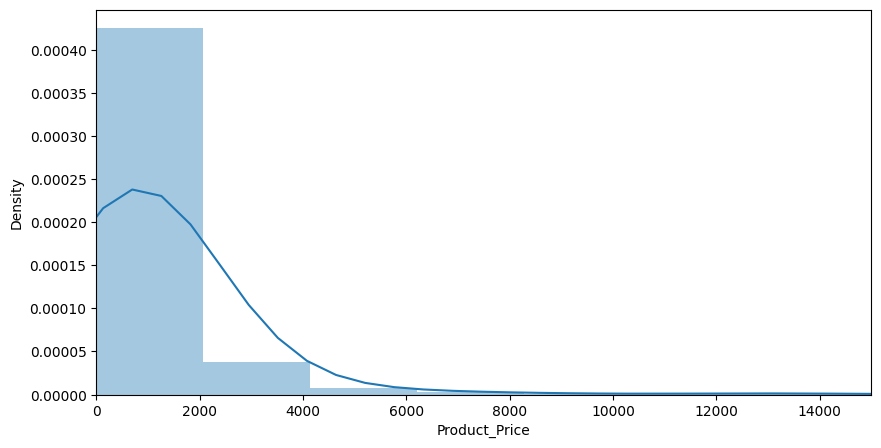

In [ ]:
# Price distribution of product dataset
plt.figure(figsize=(10,5))
ax=sns.distplot(data["Product_Price"])
ax.set_xlim(0, 15000)

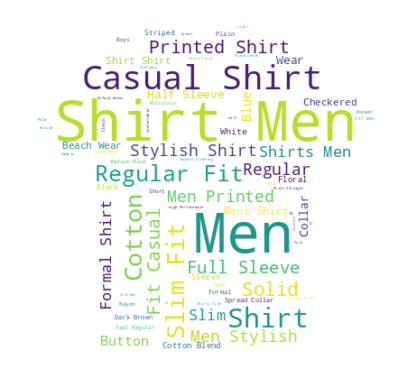

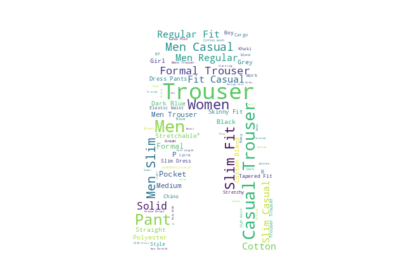

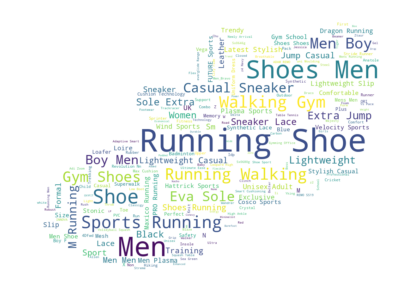

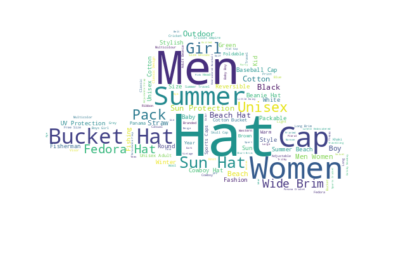

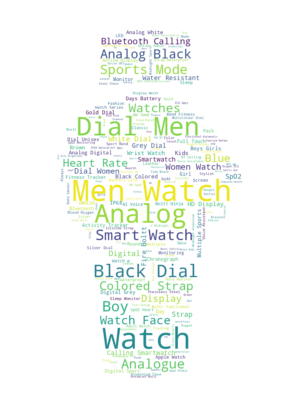

In [ ]:
# Wordclouds

# Accepts apparel class and returns product name joined with a space
def product_join(name):
    return " ".join(t for t in data[data["output"]==name].Product_name)

# Load mask images
shirt_mask = np.array(Image.open(path.join("shirt.jpg")))
trousers_mask = np.array(Image.open(path.join("trousers.jpg")))
shoe_mask = np.array(Image.open(path.join("shoe.jpeg")))
hat_mask = np.array(Image.open(path.join("hat.jpg")))
watch_mask = np.array(Image.open(path.join("watch.jpg")))
list_masks = [shirt_mask, trousers_mask, shoe_mask, hat_mask, watch_mask] 
list_name=["shirt", "trousers", "shoe", "hat", "watch"] 

for i in range(len(list_masks)):
    wordcloud = WordCloud(background_color="white",  mask=list_masks[i]).generate(product_join(list_name[i]))
    plt.figure(figsize=[5,5])
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [ ]:
# Class Distribution
pd.DataFrame(data['output'].value_counts())

,output
shoe,385
shirt,359
hat,354
trousers,340
watch,339


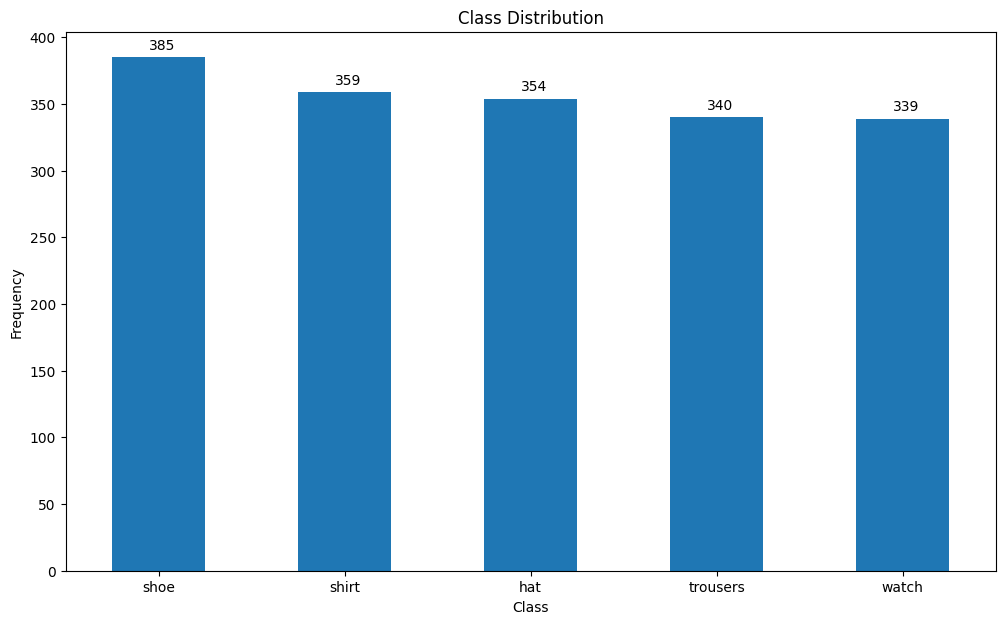

In [ ]:
# Plotting class distribution
plt.figure(figsize=(12,7))
count_classes = pd.value_counts(data['output'], sort = True)
ax=count_classes.plot(kind = 'bar', rot=0)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Frequency")
for p in ax.patches:
      ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.2, p.get_height()+6))
plt.show()

shirt
trousers
shoe
hat
watch


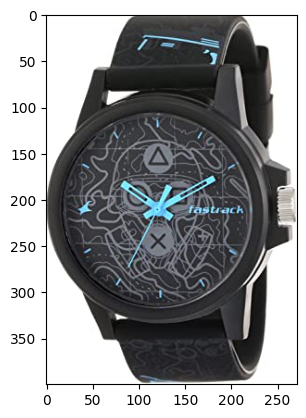

In [ ]:
# Accepts image url and returns picture
def display_img(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    return plt.imshow(img)

for i in (300, 600, 900, 1200, 1500):
    display_img(data['Product_Image'][i])
    print(data['output'][i])

# **Image Classification** <a class="anchor" id="1"></a>

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, losses
from tensorflow.random import set_seed
from tensorflow.keras import regularizers 
from keras.layers.core import Dropout
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.applications import vgg16
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.applications.imagenet_utils import preprocess_input

In [ ]:
# Accepts image url and converts image to array after resizing to uniform size
def img_array(img):   
    response = urllib.request.urlopen(img)
    image = np.asarray(bytearray(response.read()), dtype="uint8") 
    image_bgr = cv2.imdecode(image, cv2.IMREAD_COLOR)
    image_bgr = cv2.resize(image_bgr, (224,224))
    return image_bgr

# Storing all images in dataset into arrays
image_array=[]
for i in data['Product_Image']:
    image_array.append(img_array(i))
    
img_arr=np.array(image_array)

In [ ]:
# Encoding categorical string class labels into categorical numeric
data['output'][data['output']=='shirt']=0
data['output'][data['output']=='trousers']=1
data['output'][data['output']=='shoe']=2
data['output'][data['output']=='hat']=3
data['output'][data['output']=='watch']=4
data['output']=data['output'].astype(int)

# Train-Test Split
train_images, test_images, train_labels, test_labels=train_test_split(img_arr, data['output'], test_size=0.30, random_state=42, shuffle=True)

# Normalize pixel values of image (between 0 and 1)
train_images, test_images = train_images / 255.0, test_images / 255.0

In [ ]:
# CNN for Image Classification
set_seed(42)
cnn = Sequential()

# Convolutional layers
cnn.add(layers.Conv2D(filters = 32, kernel_size = (3, 3), activation='relu', input_shape=train_images[0].shape, kernel_regularizer=regularizers.l1(1e-5)))
cnn.add(layers.MaxPooling2D(pool_size = (2, 2)))
cnn.add(Dropout(.20))
cnn.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(Dropout(.20))
cnn.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(Dropout(.20))

# Fully-connected layers
cnn.add(layers.Flatten())
cnn.add(layers.Dense(32, activation='relu'))
cnn.add(Dropout(.20))
cnn.add(layers.Dense(5, activation='softmax'))

In [ ]:
# Compile the model
cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# Fit the model
model = cnn.fit(train_images, train_labels, epochs=10, validation_split=0.2, callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3))

Epoch 1/10
32/32 [==============================] - 114s 4s/step - loss: 1.6404 - accuracy: 0.2153 - val_loss: 1.5435 - val_accuracy: 0.4498
Epoch 2/10
32/32 [==============================] - 113s 4s/step - loss: 1.1587 - accuracy: 0.5473 - val_loss: 0.9431 - val_accuracy: 0.7430
Epoch 3/10
32/32 [==============================] - 112s 4s/step - loss: 0.7160 - accuracy: 0.7374 - val_loss: 0.6110 - val_accuracy: 0.8353
Epoch 4/10
32/32 [==============================] - 112s 3s/step - loss: 0.5173 - accuracy: 0.8129 - val_loss: 0.4399 - val_accuracy: 0.8795
Epoch 5/10
32/32 [==============================] - 112s 4s/step - loss: 0.4370 - accuracy: 0.8280 - val_loss: 0.4615 - val_accuracy: 0.8233
Epoch 6/10
32/32 [==============================] - 114s 4s/step - loss: 0.3670 - accuracy: 0.8551 - val_loss: 0.4619 - val_accuracy: 0.8594
Epoch 7/10
32/32 [==============================] - 113s 4s/step - loss: 0.2270 - accuracy: 0.9165 - val_loss: 0.3609 - val_accuracy: 0.8835
Epoch 8/10
32

In [ ]:
cnn.save('/model_cnn.h5')

In [ ]:
# Prediction on the test image
cnn_pred = cnn.predict(test_images, verbose=1)
cnn_pred = np.argmax(cnn_pred, axis=1)

17/17 [==============================] - 19s 1s/step


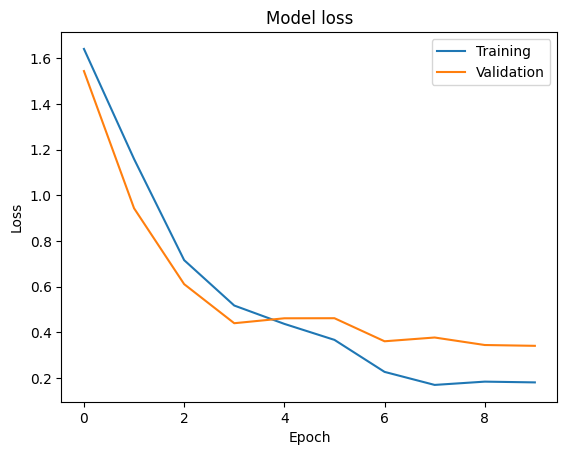

In [ ]:
plt.plot(model.history['loss'])
plt.plot(model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
print("Accuracy : ", cnn.evaluate(test_images, test_labels))

17/17 [==============================] - 15s 835ms/step - loss: 0.2681 - accuracy: 0.9288
Accuracy :  [0.2681231200695038, 0.9288389682769775]


<Axes: >

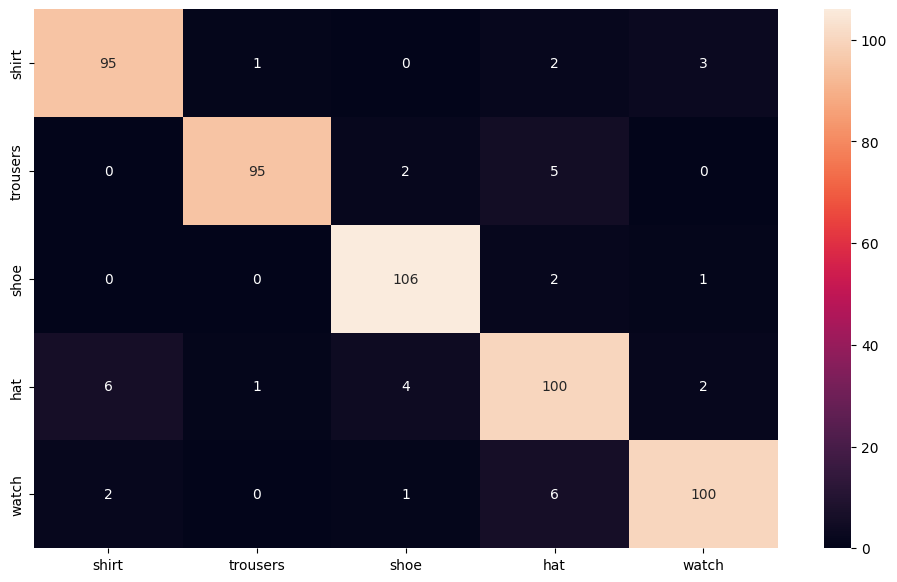

In [ ]:
classes = ('shirt', 'trousers', 'shoe', 'hat', 'watch')
cf_matrix = confusion_matrix(test_labels, cnn_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True, fmt='g')
#plt.savefig(conf_matrix_map)

In [ ]:
test_labels=test_labels.tolist() # converting the test_labels into a list 

# Creating a function which picks random images and identifies the class to which the image belongs
def get_image_and_class(size):
  idx = np.random.randint(len(test_images), size=size) # generating a random image from the test data
  for i in range(len(idx)):
    plt.imshow(test_images[idx,:][i]) 
    plt.show()
    
  # Print the class of the random image picked above
    if test_labels[idx[i]] == 0:
      print('Shirt')
    elif test_labels[idx[i]] == 1:
      print('Trousers')
    elif test_labels[idx[i]] == 2:
      print('Shoe')
    elif test_labels[idx[i]] == 3:
      print('Hat')
    elif test_labels[idx[i]] == 4:
      print('Watch')

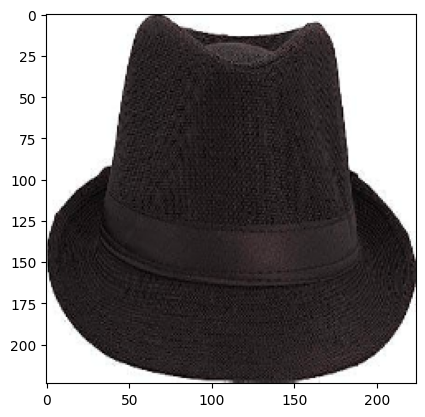

Hat


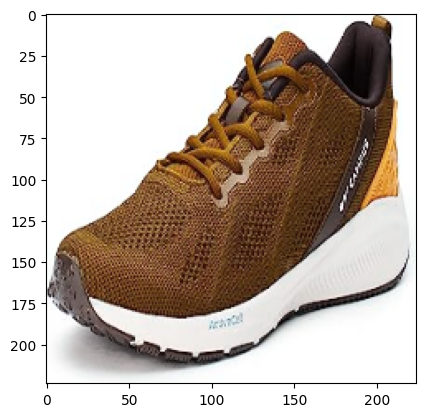

Shoe


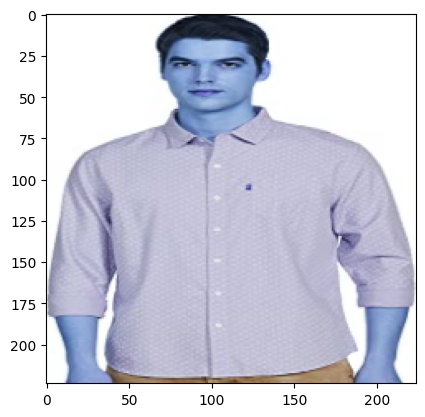

Shirt


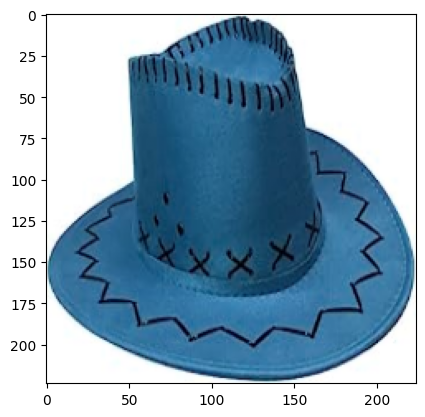

Hat


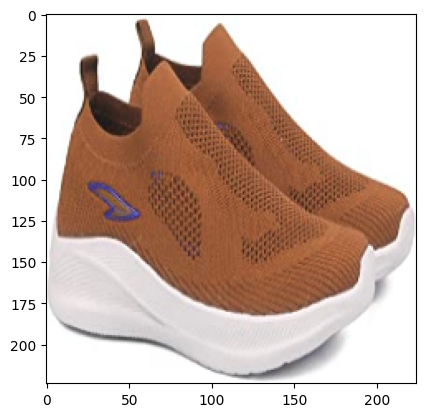

Shoe


In [ ]:
get_image_and_class(5)

# **Product Recommendation** <a class="anchor" id="2"></a>

## **1. Text Based Recommendation** <a class="anchor" id="2.1"></a>

### **A. Recommendation based on product title** <a class="anchor" id="2.1.1"></a>

In [ ]:
count_vectorize = CountVectorizer(stop_words = 'english')
title_vectorized = count_vectorize.fit_transform(data['Product_name'])
title_vectorized.shape

(1777, 1767)

In [ ]:
# Representation of count vectorizer
counts = pd.DataFrame(title_vectorized.toarray(),columns=count_vectorize.get_feature_names_out())
counts

,003_blue_free,01,01_camouflage,01_white_free,02,03,04,05,06,07,...,z126,z146,z2,z3,z4,z6,zebronics,zero,zoom,ztaur
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1772,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1773,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1774,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1775,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
cosine_sim_user2 = cosine_similarity(title_vectorized, title_vectorized)

cosine_sim_users2_df=pd.DataFrame(cosine_sim_user2)
cosine_sim_users2_df.columns=data['Product_name']
cosine_sim_users2_df.index=data['Product_name']
cosine_sim_users2_df

Product_name,"Replay Full Sleeves White Shirt with Regular Collar Casual/Formal Shirt | 100% Cotton Fabric, Full Sleeve, Regular Collar Shirt for Men, Regular Fit","Wave Full Sleeves White Formal Shirt with Regular Collar | Cotton Stretch Fabric, Full Sleeve, Regular Collar Shirt for Men, Slim Fit",Men's Cotton Full Sleeve Slim Fit Casual Solid Shirt,White Solid Cotton Full Sleeves Casual Shirt for Men II Stylish Shirt for Men II Exclusive Latest Men Casual Shirt II Luxury Shirts || Branded White Shirt for Men ||,Men's Solid Slim Fit Cotton Casual Shirt with Spread Collar & Full Sleeves,Men's Regular Casual Shirt,Men's Regular Fit Formal Shirt,Slim Fit Cotton Blend Formal Shirts for Men,Men Casual Shirts,Men Casual Shirt,...,Digital Baby Boy's Watch (Black Dial Black Colored Strap),Analog Rose Gold Dial Women's Watch-NM6147NM01 / NL6147NL01/NP6147NM01,"Smart Watch for men women boys 1.3 OLED HD Display, Multiple watch Faces, SpO2 Monitoring, Sleep Monitor for Boys, Girls, Mens, Women & Kids for all Smartphones (ID 116 Plus Black) (ID116 Black)",Edifice Stopwatch Men's Chronograph EFR-539BK-1AVUDF (EX187),Grant Chronograph Black Dial Men's Watch-FS4832,Analog Men's Watch (Brown Dial Brown Colored Strap),Analogue Silver Dial Men's & Boy's Watch RWS0276S,Analog Men's Watch (Brown Dial Brown Colored Strap),Analog Men's Watch (Gold Dial Colored Strap),Grant Chronograph Black Dial Men's Watch-FS4832
Product_name,,,,,,,,,,,,,,,,,,,,,
"Replay Full Sleeves White Shirt with Regular Collar Casual/Formal Shirt | 100% Cotton Fabric, Full Sleeve, Regular Collar Shirt for Men, Regular Fit",1.000000,0.871145,0.492366,0.502865,0.550482,0.696311,0.700649,0.263181,0.201008,0.502519,...,0.000000,0.000000,0.029424,0.061546,0.065795,0.055048,0.065795,0.055048,0.065795,0.065795
"Wave Full Sleeves White Formal Shirt with Regular Collar | Cotton Stretch Fabric, Full Sleeve, Regular Collar Shirt for Men, Slim Fit",0.871145,1.000000,0.516047,0.438069,0.593442,0.521286,0.652753,0.394055,0.120386,0.361158,...,0.000000,0.000000,0.035245,0.073721,0.078811,0.065938,0.078811,0.065938,0.078811,0.078811
Men's Cotton Full Sleeve Slim Fit Casual Solid Shirt,0.492366,0.516047,1.000000,0.557086,0.782624,0.530330,0.474342,0.534522,0.408248,0.612372,...,0.000000,0.000000,0.059761,0.125000,0.133631,0.111803,0.133631,0.111803,0.133631,0.133631
White Solid Cotton Full Sleeves Casual Shirt for Men II Stylish Shirt for Men II Exclusive Latest Men Casual Shirt II Luxury Shirts || Branded White Shirt for Men ||,0.502865,0.438069,0.557086,1.000000,0.539796,0.656532,0.469776,0.297775,0.530669,0.758098,...,0.000000,0.000000,0.088779,0.185695,0.198517,0.166091,0.198517,0.166091,0.198517,0.198517
Men's Solid Slim Fit Cotton Casual Shirt with Spread Collar & Full Sleeves,0.550482,0.593442,0.782624,0.539796,1.000000,0.474342,0.424264,0.478091,0.365148,0.547723,...,0.000000,0.000000,0.053452,0.111803,0.119523,0.100000,0.119523,0.100000,0.119523,0.119523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Analog Men's Watch (Brown Dial Brown Colored Strap),0.055048,0.065938,0.111803,0.166091,0.100000,0.158114,0.141421,0.119523,0.182574,0.182574,...,0.381385,0.316228,0.160357,0.111803,0.358569,1.000000,0.358569,1.000000,0.717137,0.358569
Analogue Silver Dial Men's & Boy's Watch RWS0276S,0.065795,0.078811,0.133631,0.198517,0.119523,0.188982,0.169031,0.142857,0.218218,0.218218,...,0.341882,0.251976,0.191663,0.133631,0.428571,0.358569,1.000000,0.358569,0.428571,0.428571
Analog Men's Watch (Brown Dial Brown Colored Strap),0.055048,0.065938,0.111803,0.166091,0.100000,0.158114,0.141421,0.119523,0.182574,0.182574,...,0.381385,0.316228,0.160357,0.111803,0.358569,1.000000,0.358569,1.000000,0.717137,0.358569


In [ ]:
# Accepts PID, Number of most similar products to recommend
def text_recommend_1(pid, num_recommend):
    cosine_sim = cosine_similarity(title_vectorized, title_vectorized)

    recommended_prod = []
    score=[]
    
    # Displaying query product - PID, Name, Brand
    print("-----------------------------------------------------------------------")
    print("Original product:")
    print("-----------------------------------------------------------------------")
    print("Product ID : " , pid)
    print("Title : ", data['Product_name'][data['PID']==pid].item())
    print("Brand : ", data['Product_Brand'][data['PID']==pid].item())
    print("Price : ",data['Product_Price'][data['PID']==pid].item())
    print("Reviews : ",data['Product_Reviews'][data['PID']==pid].item())
    print("Rating : ",data['Product_Rating'][data['PID']==pid].item())
    
    # Getting indexes, scores of N most similar products
    score_series = pd.Series(cosine_sim[pid]).sort_values(ascending = False)
    top_10_indexes = list(score_series.iloc[1:(num_recommend+1)].index)
    top_10_score=list(score_series.iloc[1:(num_recommend+1)])
    
    # Displaying recommended products - Image, PID, Name, Brand, Similarity Score
    print("\n")
    print("-----------------------------------------------------------------------")
    print("Most similar products:")
    print("-----------------------------------------------------------------------")
    
    for i in range(0,len(top_10_score)):
        recommended_prod.append(list(data['Product_name'])[i])
        print("\nProduct ID : " , top_10_indexes[i])
        print("Title : ", data['Product_name'][data['PID']==top_10_indexes[i]].item())
        print("Brand : ", data['Product_Brand'][data['PID']==top_10_indexes[i]].item())
        print("Price : ",data['Product_Price'][data['PID']==top_10_indexes[i]].item())
        print("Reviews : ",data['Product_Reviews'][data['PID']==top_10_indexes[i]].item())
        print("Rating : ",data['Product_Rating'][data['PID']==top_10_indexes[i]].item())
        print("Similarity score : ",top_10_score[i])
    

In [ ]:
text_recommend_1(1000,5)

-----------------------------------------------------------------------
Original product:
-----------------------------------------------------------------------
Product ID :  1000
Title :  Men Black Walking Shoes
Brand :  Red Tape


-----------------------------------------------------------------------
Most similar products:
-----------------------------------------------------------------------

Product ID :  732
Title :  Men's Walking Shoes
Brand :  Red Tape
Similarity score :  0.8660254037844388

Product ID :  1026
Title :  Men's Walking Shoes
Brand :  Red Tape
Similarity score :  0.8660254037844388

Product ID :  936
Title :  Men's Walking Shoes
Brand :  Red Tape
Similarity score :  0.8660254037844388

Product ID :  895
Title :  Men's Walking Shoes
Brand :  Red Tape
Similarity score :  0.8660254037844388

Product ID :  855
Title :  Men's Black Running Shoes
Brand :  ASICS
Similarity score :  0.75


### **B. Recommendation based on product title and brand** <a class="anchor" id="2.1.1"></a>

In [ ]:
brand_vectors = CountVectorizer(stop_words = 'english')
brand_vectorized = brand_vectors.fit_transform(data['Product_Brand'])

In [ ]:
# Accepts PID, Number of most similar products to recommend, weights for the word-2-vec features: product name and brand
def text_recommend_2(pid, num_recommend, w1, w2):
    title_sim  = cosine_similarity(title_vectorized, title_vectorized)
    brand_sim = cosine_similarity(brand_vectorized, brand_vectorized)
    total_sim   = (w1 * title_sim +  w2 * brand_sim)/float(w1 + w2)

    recommended_prod = []
    score=[]
    
    # Displaying query product - PID, Name, Brand
    print("-----------------------------------------------------------------------")
    print("Original product:")
    print("-----------------------------------------------------------------------")
    print("Product ID : " , pid)
    print("Title : ", data['Product_name'][data['PID']==pid].item())
    print("Brand : ", data['Product_Brand'][data['PID']==pid].item())
    print("Price : ",data['Product_Price'][data['PID']==pid].item())
    print("Reviews : ",data['Product_Reviews'][data['PID']==pid].item())
    print("Rating : ",data['Product_Rating'][data['PID']==pid].item())

    # Getting indexes, scores of N most similar products
    score_series = pd.Series(total_sim[pid]).sort_values(ascending = False)
    top_indexes = list(score_series.iloc[1:(num_recommend+1)].index)
    top_score=list(score_series.iloc[1:(num_recommend+1)])
            
    # Displaying recommended products - Image, PID, Name, Brand, Similarity Score
    print("\n")
    print("-----------------------------------------------------------------------")
    print("Most similar products:")
    print("-----------------------------------------------------------------------")
    
    for i in range(0,len(top_score)):
        recommended_prod.append(list(data['Product_name'])[i])
        print("\nProduct ID : " , top_indexes[i])
        print("Title : ", data['Product_name'][data['PID']==top_indexes[i]].item())
        print("Brand : ", data['Product_Brand'][data['PID']==top_indexes[i]].item())
        print("Price : ",data['Product_Price'][data['PID']==top_indexes[i]].item())
        print("Reviews : ",data['Product_Reviews'][data['PID']==top_indexes[i]].item())
        print("Rating : ",data['Product_Rating'][data['PID']==top_indexes[i]].item())
        print("Similarity score : ",top_score[i])
    
    

In [ ]:
text_recommend_2(1000,5,0.75,0.25)

-----------------------------------------------------------------------
Original product:
-----------------------------------------------------------------------
Product ID :  1000
Title :  Men Black Walking Shoes
Brand :  Red Tape


-----------------------------------------------------------------------
Most similar products:
-----------------------------------------------------------------------

Product ID :  1026
Title :  Men's Walking Shoes
Brand :  Red Tape
Similarity score :  0.899519052838329

Product ID :  895
Title :  Men's Walking Shoes
Brand :  Red Tape
Similarity score :  0.899519052838329

Product ID :  936
Title :  Men's Walking Shoes
Brand :  Red Tape
Similarity score :  0.899519052838329

Product ID :  732
Title :  Men's Walking Shoes
Brand :  Red Tape
Similarity score :  0.899519052838329

Product ID :  1019
Title :  Men Olive Walking Shoes
Brand :  Red Tape
Similarity score :  0.8125


## **2. Image Based Recommendation** <a class="anchor" id="2.2"></a>

In [ ]:
# load the model
vgg_model = vgg16.VGG16(weights='imagenet')

# remove the last layers in order to get features instead of predictions
feat_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer("fc2").output)

# print the layers of the CNN
feat_extractor.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
imgs_path = "images/"

# Downloading all images from urls
"""
for idx, row in data.iterrows():
    url = row['Product_Image']
    if(url!='nan' and url):
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        img.save(imgs_path + str(row['PID']) + '.jpeg')
"""

imgs_model_width, imgs_model_height = 224,224

files = [imgs_path + x for x in os.listdir(imgs_path) if "jpeg" in x]

print("Number of images:",len(files))

Number of images: 1777


In [ ]:
# Extracting PID from file names
_re_digits = re.compile(r'\d+')
pid = []
for element in files:
    pid += [int(n) for n in _re_digits.findall(element)]

# Adding pid and image url to a dataframe
df={'PID':pid,'Images':files}
df=pd.DataFrame(df)

# Preprocessing images for feeding into CNN (VGG16)
importedImages = []

for f in files:
    filename = f
    original = load_img(filename, target_size=(224, 224))
    numpy_image = img_to_array(original)
    image_batch = np.expand_dims(numpy_image, axis=0)
    importedImages.append(image_batch)
    
images = np.vstack(importedImages)

processed_imgs = preprocess_input(images.copy())

In [ ]:
# Extracting image features
imgs_features = feat_extractor.predict(processed_imgs)
print("Features successfully extracted.")
imgs_features.shape

56/56 [==============================] - 1099s 20s/step
Features successfully extracted!


(1777, 4096)

In [ ]:
# Computing and storing cosine similarities between images
cosSimilarities = cosine_similarity(imgs_features)
cos_similarities_df = pd.DataFrame(cosSimilarities, columns=files, index=files)
cos_similarities_df

,images/1090.jpeg,images/675.jpeg,images/1057.jpeg,images/151.jpeg,images/803.jpeg,images/333.jpeg,images/560.jpeg,images/68.jpeg,images/279.jpeg,images/1285.jpeg,...,images/1764.jpeg,images/1079.jpeg,images/1597.jpeg,images/367.jpeg,images/469.jpeg,images/311.jpeg,images/1586.jpeg,images/1109.jpeg,images/52.jpeg,images/1685.jpeg
images/1090.jpeg,1.000000,0.282173,0.448211,0.250266,0.354339,0.296090,0.248240,0.323320,0.367836,0.352350,...,0.090769,0.448408,0.129879,0.269163,0.333036,0.233140,0.143408,0.352026,0.244134,0.310085
images/675.jpeg,0.282173,1.000000,0.312233,0.467125,0.224732,0.433076,0.524198,0.487084,0.487479,0.284922,...,0.136461,0.260835,0.256170,0.650098,0.662997,0.501949,0.182079,0.274719,0.501044,0.240705
images/1057.jpeg,0.448211,0.312233,1.000000,0.200527,0.702814,0.386754,0.289211,0.256988,0.333502,0.210673,...,0.180262,0.731507,0.201772,0.274559,0.377840,0.221474,0.299928,0.206028,0.275415,0.356682
images/151.jpeg,0.250266,0.467125,0.200527,1.000000,0.191080,0.331813,0.423765,0.677268,0.738435,0.368671,...,0.105860,0.204602,0.159430,0.585323,0.484937,0.770612,0.145239,0.423495,0.314774,0.124249
images/803.jpeg,0.354339,0.224732,0.702814,0.191080,1.000000,0.234705,0.191659,0.205855,0.255172,0.142536,...,0.162702,0.727479,0.191576,0.194334,0.248890,0.193284,0.253908,0.195468,0.152209,0.354253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
images/311.jpeg,0.233140,0.501949,0.221474,0.770612,0.193284,0.304289,0.415301,0.693828,0.664307,0.309040,...,0.089107,0.209031,0.194903,0.603754,0.501789,1.000000,0.133275,0.338511,0.386960,0.133189
images/1586.jpeg,0.143408,0.182079,0.299928,0.145239,0.253908,0.226023,0.158677,0.164252,0.211878,0.070012,...,0.454475,0.231770,0.490610,0.123198,0.203260,0.133275,1.000000,0.143057,0.154228,0.204235
images/1109.jpeg,0.352026,0.274719,0.206028,0.423495,0.195468,0.253988,0.255416,0.329189,0.425591,0.395362,...,0.106359,0.207904,0.096193,0.322564,0.288104,0.338511,0.143057,1.000000,0.230433,0.194138
images/52.jpeg,0.244134,0.501044,0.275415,0.314774,0.152209,0.380369,0.421136,0.327600,0.395718,0.257728,...,0.113765,0.163878,0.219941,0.525936,0.437542,0.386960,0.154228,0.230433,1.000000,0.208875


In [ ]:
# Accepts PID, Number of most similar products to recommend
def image_recommend_1(pid, num_recommend = 5):
    given_img=df['Images'][df['PID']==pid].item()
    
    # Displaying query product- Image, PID, Name, Brand
    print("-----------------------------------------------------------------------")
    print("Original product:")
    print("-----------------------------------------------------------------------")
    
    print("\nProduct ID : ",pid)
    print("Title : ",data['Product_name'][data['PID']==pid].item())
    print("Brand : ",data['Product_Brand'][data['PID']==pid].item())
    print("Price : ",data['Product_Price'][data['PID']==pid].item())
    print("Reviews : ",data['Product_Reviews'][data['PID']==pid].item())
    print("Rating : ",data['Product_Rating'][data['PID']==pid].item())
    original = load_img(given_img, target_size=(imgs_model_width, imgs_model_height))
    plt.imshow(original)
    plt.show()
    
    # Getting indexes, scores of N most similar products
    closest_imgs = cos_similarities_df[given_img].sort_values(ascending=False)[1:num_recommend+1].index
    closest_imgs_scores = cos_similarities_df[given_img].sort_values(ascending=False)[1:num_recommend+1]
    
    # Extracting PIDs from image files
    _re_digits = re.compile(r'\d+')
    closest_imgs_pid = []
    for element in closest_imgs:
        closest_imgs_pid += [int(n) for n in _re_digits.findall(element)]
    
    # Displaying recommended products - Image, PID, Name, Brand, Similarity Score
    print("-----------------------------------------------------------------------")
    print("Most similar products:")
    print("-----------------------------------------------------------------------") 
    
    for i in range(0,len(closest_imgs)):
        print("\nProduct ID : ",closest_imgs_pid[i])
        print("Title : ",data['Product_name'][data['PID']==closest_imgs_pid[i]].item())
        print("Brand : ",data['Product_Brand'][data['PID']==closest_imgs_pid[i]].item())
        print("Price : ",data['Product_Price'][data['PID']==closest_imgs_pid[i]].item())
        print("Reviews : ",data['Product_Reviews'][data['PID']==closest_imgs_pid[i]].item())
        print("Rating : ",data['Product_Rating'][data['PID']==closest_imgs_pid[i]].item())
        print("similarity score : ",closest_imgs_scores[i])
        
        original = load_img(closest_imgs[i], target_size=(imgs_model_width, imgs_model_height))
        plt.imshow(original)
        plt.show()  

-----------------------------------------------------------------------
Original product:
-----------------------------------------------------------------------

Product ID :  1000
Title :  Men Black Walking Shoes
Brand :  Red Tape
Price :  1724.0
Reviews :  2.0
Rating :  4.5


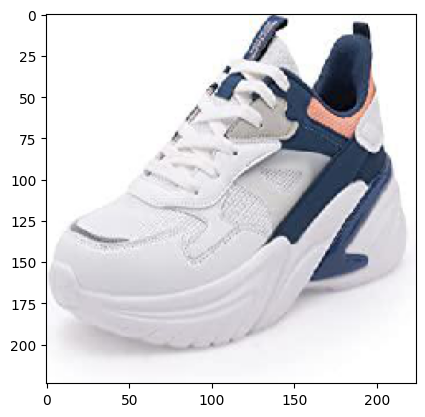

-----------------------------------------------------------------------
Most similar products:
-----------------------------------------------------------------------

Product ID :  1019
Title :  Men Olive Walking Shoes
Brand :  Red Tape
Price :  1724.0
Reviews :  30.0
Rating :  3.9
similarity score :  0.9124498


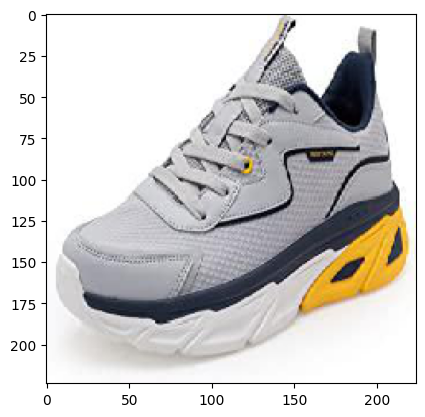


Product ID :  977
Title :  Men's FUTURE-01 Sports Running,Walking & Gym Shoes with Eva Sole Extra Jump Casual Sneaker Shoes for Men's & Boy's
Brand :  ASIAN
Price :  524.0
Reviews :  6754.0
Rating :  3.8
similarity score :  0.88335276


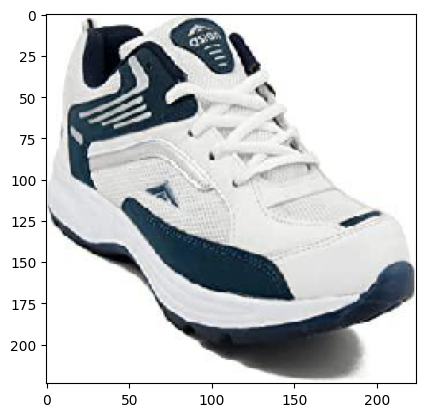


Product ID :  757
Title :  Men's Running Shoes
Brand :  ASIAN
Price :  524.0
Reviews :  6754.0
Rating :  3.8
similarity score :  0.8822391


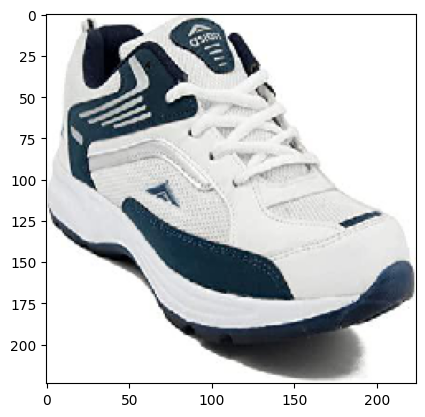


Product ID :  942
Title :  Men's FUTURE-01 Sports Running,Walking & Gym Shoes with Eva Sole Extra Jump Casual Sneaker Shoes for Men's & Boy's
Brand :  ASIAN
Price :  524.0
Reviews :  6754.0
Rating :  3.8
similarity score :  0.8822391


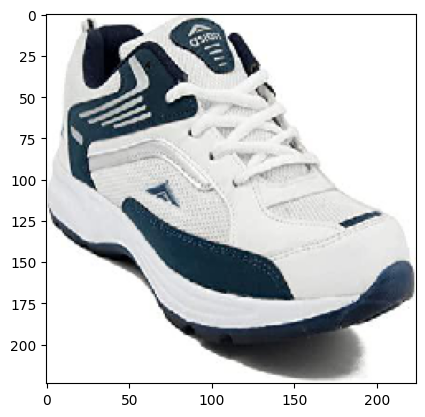


Product ID :  889
Title :  Men's FUTURE-01 Sports Running,Walking & Gym Shoes with Eva Sole Extra Jump Casual Sneaker Shoes for Men's & Boy's
Brand :  ASIAN
Price :  524.0
Reviews :  6754.0
Rating :  3.8
similarity score :  0.88055366


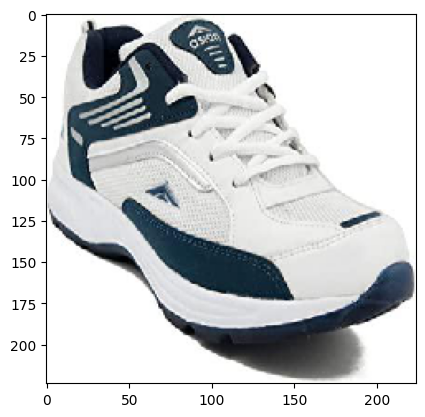

In [ ]:
image_recommend_1(1000,5)